In [2]:
from scripts import preprocessing_old
from scripts import predict_stromfluss
from scripts import preprocessing_weatherdata
from scripts import preprocessing_plannedProduction
from scripts import preprocessing_trade_price_consumption
from bda import bda_utilities
import pandas as pd
import numpy as np
import os.path

## Preprocessing

Load and format power flow.

In [3]:
df = predict_stromfluss.read_data_stromfluss('./data/stromfluss')
df = predict_stromfluss.preprocessing_stromfluss(df)

In [4]:
def create_net_columns(df):
    countries = ["NL", "CHE", "DNK", "CZE", "LUX", "SWE", "AUT", "FRA", "PL"]
    for country in countries:
        im_key = country + "_IM"
        ex_key = country + "_EX"
        df[country]=df[im_key] +df[ex_key]
        df = df.drop(columns=[im_key,ex_key])
    return df


In [5]:
df = create_net_columns(df)
df = df.rename(columns={"Date":"date"})
df.head()

,date,NX,NL,CHE,DNK,CZE,LUX,SWE,AUT,FRA,PL
0,2015-06-01 00:00:00,7279.0,3932.0,145.0,-272.0,554.0,0.0,1.0,1394.0,246.0,1279.0
1,2015-06-01 01:00:00,7167.0,4014.0,261.0,-141.0,469.0,0.0,1.0,1355.0,66.0,1142.0
2,2015-06-01 02:00:00,6667.0,3864.0,103.0,-326.0,422.0,0.0,1.0,1574.0,-105.0,1134.0
3,2015-06-01 03:00:00,6413.0,4242.0,42.0,-262.0,235.0,0.0,1.0,1271.0,-206.0,1090.0
4,2015-06-01 04:00:00,5347.0,4292.0,-127.0,-582.0,161.0,0.0,1.0,1068.0,-549.0,1083.0


Load and format weather data. 

In [6]:
df_weather = preprocessing_weatherdata.import_weatherData()
df_weather = df_weather[df_weather['date'].dt.year >= 2015]
df_weather.head()

,date,DE_av_windspeed_ms_north,DE_percip_mm_north,DE_sun_hrs_north,DE_av_windspeed_ms_south,DE_percip_mm_south,DE_sun_hrs_south,DK_sun_hrs,DK_av_windSpeed_ms,CZ_av_temperatureChange,CZ_av_windSpeed,FR_av_temperatureChange,FR_av_windSpeed
48942,2015-01-01,7.336364,-112.171429,2.980412,2.880556,0.065789,2.053026,0.0,8.4,NaN,NaN,NaN,NaN
48943,2015-01-02,10.930303,-112.431429,0.984794,5.925714,3.997368,0.451316,2.0,12.0,NaN,NaN,NaN,NaN
48944,2015-01-03,8.972727,-111.354286,0.045118,4.957143,14.647368,0.111895,2.5,8.2,NaN,NaN,NaN,NaN
48945,2015-01-04,7.393939,-113.365714,3.463676,4.774286,1.015789,1.045184,5.2,6.0,NaN,NaN,NaN,NaN
48946,2015-01-05,5.606061,-113.351429,0.894176,3.035294,0.168421,4.415789,0.3,3.2,NaN,NaN,NaN,NaN


In [7]:
#make hourly
df_weather = bda_utilities.make_hourly(df_weather)

In [8]:
# Weather data for CZ and FR only start in 2017, so we drop them
df_weather.set_index("date").iloc[:,8:].plot()
df_weather = df_weather.drop(columns=df_weather.columns[8:])

In [9]:
# Percipitation has probably no effect on power flow, so we drop those as well 
df_weather = df_weather.drop(columns=[col for col in df_weather.columns if "percip" in col])

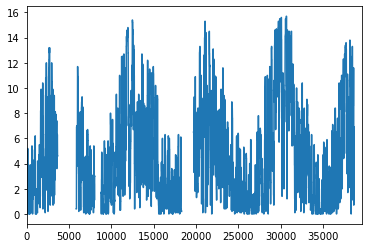

In [10]:
# DK sun hours has great portions of missing values, so we drop it . 
df_weather['DK_sun_hrs'].plot()
df_weather = df_weather.drop(columns=['DK_sun_hrs'])

Create a df containing a 24 lag for power flow values. 

In [11]:
df_24h_lag = df.copy()
df_24h_lag.set_index("date", inplace=True)
df_24h_lag = df_24h_lag.shift(+24)

def custom_column_mapper(df, append_str):
    cols = df.columns
    mapper = {}
    for col in cols:
        mapper[col]=col + append_str
    return mapper

df_24h_lag.rename(columns=custom_column_mapper(df_24h_lag, "-24h"), inplace=True)
df_24h_lag.reset_index(inplace=True)
df_24h_lag.iloc[20:28]

,date,NX-24h,NL-24h,CHE-24h,DNK-24h,CZE-24h,LUX-24h,SWE-24h,AUT-24h,FRA-24h,PL-24h
20,2015-06-01 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,2015-06-01 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2015-06-01 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,2015-06-01 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,2015-06-02 00:00:00,7279.0,3932.0,145.0,-272.0,554.0,0.0,1.0,1394.0,246.0,1279.0
25,2015-06-02 01:00:00,7167.0,4014.0,261.0,-141.0,469.0,0.0,1.0,1355.0,66.0,1142.0
26,2015-06-02 02:00:00,6667.0,3864.0,103.0,-326.0,422.0,0.0,1.0,1574.0,-105.0,1134.0
27,2015-06-02 03:00:00,6413.0,4242.0,42.0,-262.0,235.0,0.0,1.0,1271.0,-206.0,1090.0


Check other external information: trade, price, and consumption

In [12]:
# All this data is only until 2017. Is there more recent data? 
# For now, don't include these in the master dataframe

df_consumption = preprocessing_trade_price_consumption.import_consumptionData()
df_consumption.plot()

df_price = preprocessing_trade_price_consumption.import_priceData()
df_price.set_index("date").plot()

df_trade = preprocessing_trade_price_consumption.import_foreignTradeData()
df_trade.set_index("date").plot()

NameError: name 'numberparse' is not defined

Make master dataframe containing all the information. 

In [357]:
df_master = df.copy()
df_master = df_master.merge(df_24h_lag)
df_master = df_master.merge(df_weather)

# split up datetime information, keep date as index for easier manipulation
df_master.set_index(['date'], append=True, inplace=True, drop=False)
df_master = bda_utilities.split_datetime(df_master)


NameError: name 'df_24h_lag' is not defined

In [14]:
# move datetime columns to the front for readibility

# It is bugged, i don't know why 
def move_columns_to_front(df, front_column_names): 
    '''
    Returns a list with reordered column names 
    '''
    columns = list(df.columns)
    for col in front_column_names:
        if col not in columns:
            front_column_names.remove(col) 
    for col in columns:
        if col in front_column_names:
            columns.remove(col)
    result = front_column_names + columns
    return result

# Static hotfix
def move_columns_to_front_static(df, front_column_names):
    result = move_columns_to_front(df, front_column_names)
    result.pop(-1)
    result.pop(-1)
    return result
    

column_order = move_columns_to_front_static(df_master, front_column_names=["year","month","weekday","hour","timestamp"])
df_master = df_master.loc[:,column_order]

C:\Users\Laurin\Anaconda3\envs\bda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


ValueError: Item wrong length 34920 instead of 35120.

In [15]:
# Save to data 
df_master.to_csv("./data/df_master.csv")

In [394]:
df_master = pd.read_csv("./data/df_master.csv", index_col=[0,1])

## Sequence Prediction with LTSM

In [395]:
# Preprocessing master df for easier manipulation 
def make_target_columns_first(df):
    cols = [col for col in df.columns]
    country_codes = ["NX","NL","CHE","DNK","CZE","LUX","SWE",'AUT', "FRA", "PL"]
    cols = country_codes + cols
    cols = list(dict.fromkeys(cols))
    return cols

new_column_order = make_target_columns_first(df_master)
df = df_master[new_column_order].copy()
df.reset_index(level=0, drop=True, inplace=True)
df.index = pd.to_datetime(df.index)

In [396]:
# Drop outliers
def get_outliers(df, factor):
    idxs = df[df['NX'] > df['NX'].mean() + factor * df['NX'].std()]
    return idxs
df.drop(get_outliers(df,3).index[0], inplace=True)

In [397]:
# Drop all target columns except one country 
def delete_country_columns_except(country_code, df):
    columns = df.columns
    country_codes = ["NX","NL","CHE","DNK","CZE","LUX","SWE",'AUT', "FRA", "PL"]
    country_codes.remove(country_code)
    return country_codes

df.drop(columns=delete_country_columns_except("AUT",df), inplace=True)

In [398]:
df.head()

,AUT,year,month,weekday,hour,timestamp,NX-24h,NL-24h,CHE-24h,DNK-24h,CZE-24h,LUX-24h,SWE-24h,AUT-24h,FRA-24h,PL-24h,DE_av_windspeed_ms_north,DE_sun_hrs_north,DE_av_windspeed_ms_south,DE_sun_hrs_south
date,,,,,,,,,,,,,,,,,,,,
2015-06-01 00:00:00,1394.0,2015,6,1,0,1.433117e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.65,3.698263
2015-06-01 01:00:00,1355.0,2015,6,1,1,1.433120e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.65,3.698263
2015-06-01 02:00:00,1574.0,2015,6,1,2,1.433124e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.65,3.698263
2015-06-01 03:00:00,1271.0,2015,6,1,3,1.433128e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.65,3.698263
2015-06-01 04:00:00,1068.0,2015,6,1,4,1.433131e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.65,3.698263


In [399]:
# There are data points missing / duplicated. We will drop those days. 
from datetime import timedelta
from datetime import datetime

def find_missing_rows(df):
    last_timestamp = df.iloc[0].name
    index_list = []
    index = 0
    for date, row in df.iterrows():       
        current_timestamp = date
        if(current_timestamp != (last_timestamp + timedelta(hours=1))):
            index_list.append(index)
        last_timestamp = current_timestamp
        index = index + 1
    index_list.pop(0)
    return index_list

def find_days_with_missing_hours(df):
    index_list = find_missing_rows(df)
    dates = []
    for idx in index_list:
        date = df.iloc[idx].name
        dates.append(date.date())
    dates = list(dict.fromkeys(dates))
    return dates

def get_delete_indices(df, missing_days):
    delete_indices = []
    for day in missing_days:
        day = str(day)
        idx = df.reset_index(level=0)[day]["level_0"].values
        delete_indices.extend([x for x in idx])
    return delete_indices

In [400]:
# Delete broken days
# Darf nur einmal gemacht werden, da er sonst immer weiter an den jeweiligen Schnittpunkten löscht. 
print(len(df))
days = find_days_with_missing_hours(df)
for day in days:
    df.drop(df[str(day)].index, inplace=True)
print(len(df))

35119
34896


In [401]:
# scale dataframe
from sklearn.preprocessing import MinMaxScaler  

def scale_dataframe(dataframe):
    # load dataset
    #dataset = dataframe.copy()
    values = dataframe.values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    
    return (scaler, scaled )


scaler, scaled = scale_dataframe(df)


In [402]:
def make_sequence_of_length(length, array):
    # check for null
    if len(array.shape) == 1:
        feature_dim = 1
    else:
        feature_dim = array.shape[1]
    return array.reshape(int(array.shape[0] / length),length, feature_dim)
    

# split into train and test sets
values = scaled

# train until may until including april 2019 
training_entries = len(df[:'2019-04-30']) 
# Ignore first 24 entries, because we don't know the prior day values 
train = values[24:training_entries, :]
test = values[training_entries:, :]


# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]
# reshape input to be 3D [samples, timesteps, features]
train_X=make_sequence_of_length(24, train_X)
test_X=make_sequence_of_length(24, test_X)
# reshape output to be 3D [samples, timesteps, features]
train_y = make_sequence_of_length(24, train_y)
train_y=train_y.reshape(train_y.shape[0], train_y.shape[1])
test_y = make_sequence_of_length(24, test_y)
test_y=test_y.reshape(test_y.shape[0], test_y.shape[1])

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1421, 24, 19) (1421, 24) (32, 24, 19) (32, 24)


In [403]:
from keras.models import Sequential  
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import Dropout 
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from matplotlib import pyplot
from pandas import concat
from numpy import concatenate

In [404]:
n_steps_in = train_X.shape[1]
n_features = train_X.shape[2]
n_steps_out = train_y.shape[1]
print(n_steps_in,n_features,n_steps_out)

24 19 24


In [405]:
n_steps_in = train_X.shape[1]
n_features = train_X.shape[2]
n_steps_out = train_y.shape[1]

model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [406]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=20, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Train on 1421 samples, validate on 32 samples
Epoch 1/100
 - 7s - loss: 0.0665 - val_loss: 0.0248
Epoch 2/100
 - 2s - loss: 0.0254 - val_loss: 0.0154
Epoch 3/100
 - 2s - loss: 0.0210 - val_loss: 0.0117
Epoch 4/100
 - 2s - loss: 0.0201 - val_loss: 0.0139
Epoch 5/100
 - 2s - loss: 0.0202 - val_loss: 0.0238
Epoch 6/100
 - 2s - loss: 0.0181 - val_loss: 0.0112
Epoch 7/100
 - 2s - loss: 0.0178 - val_loss: 0.0303
Epoch 8/100
 - 2s - loss: 0.0201 - val_loss: 0.0281
Epoch 9/100
 - 2s - loss: 0.0160 - val_loss: 0.0230
Epoch 10/100
 - 2s - loss: 0.0174 - val_loss: 0.0224
Epoch 11/100
 - 2s - loss: 0.0152 - val_loss: 0.0235
Epoch 12/100
 - 2s - loss: 0.0148 - val_loss: 0.0232
Epoch 13/100
 - 2s - loss: 0.0146 - val_loss: 0.0247
Epoch 14/100
 - 2s - loss: 0.0135 - val_loss: 0.0201
Epoch 15/100
 - 2s - loss: 0.0130 - val_loss: 0.0219
Epoch 16/100
 - 2s - loss: 0.0142 - val_loss: 0.0282
Epoch 17/100
 - 2s - loss: 0.0127 - val_loss: 0.0184
Epoch 18/100
 - 2s - loss: 0.0154 - val_loss: 0.0213
Epoch 19/

KeyboardInterrupt: 

In [407]:
yhat = model.predict(test_X)
yhat.shape

(32, 24)

In [408]:
test_X = test_X.reshape((test_X.shape[0] * test_X.shape[1], test_X.shape[2]))
print(test_X.shape)
yhat = yhat.reshape((yhat.shape[0] * yhat.shape[1], 1))

inv_yhat = concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# invert scaling for actual
print(test_y.shape)
#test_y = test_y.reshape(test_y.shape[0], 1)

test_y = test_y.reshape((test_y.shape[0] * test_y.shape[1], 1))
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)




(768, 19)
(32, 24)


In [409]:
print(inv_yhat.shape, test_X.shape, yhat.shape)

(768, 20) (768, 19) (768, 1)


In [412]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 602.011


(-20000, 20000)

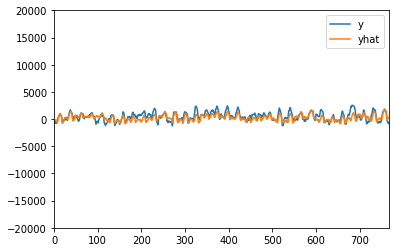

In [413]:
plotting_df = pd.DataFrame({"y":inv_y[:,0],"yhat":inv_yhat[:,0]})
ax = plotting_df.plot()
ax.set_ylim(-20000,20000)